In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import flamedisx as fd

import pickle as pkl

from copy import deepcopy

import sys
sys.path.append('../../../xlzd_reqtask_nufog')
from fogtask.fogtask import *

from tqdm.auto import tqdm

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(


In [2]:
def get_nominal_parameters(version='vFIELD_SCAN'):
    all_parameters = get_parameters(version=version, mode='LENR')
    analysis_parameters = all_parameters['wimp_analysis_parameters']
    
    ret_fix, ret_iter, nominal_parameters, template_format_string = get_template_parameters(version=version, mode='LENR')
    parameters = deepcopy(nominal_parameters)
    
    fixed_parameters = dict(
        cS1_min = analysis_parameters['cs1_range']['value'][0],
        cS1_max = analysis_parameters['cs1_range']['value'][-1],
        log10_cS2_min = analysis_parameters['cs2_range']['value'][0],
        log10_cS2_max = analysis_parameters['cs2_range']['value'][-1],
        s2_thr = analysis_parameters['s2_threshold']['value'],
        coin_level = analysis_parameters['coincidence_threshold']['value'],
        g1_gas = parameters['g1_gas'],
        temperature_K = parameters['temperature'],
        pressure_bar = parameters['pressure'],
        num_pmts = parameters['n_pmts'],
        double_pe_fraction = parameters['p_dpe'],
        s2Fano = parameters['s2_fano'],
        spe_res = parameters['spe_resolution'],
        spe_thr = parameters['spe_threshold'],
        spe_eff = parameters['spe_efficiency'],
        configuration = parameters['lce_configuration'],
        drift_field_V_cm = parameters['drift_field'],
        gas_field_kV_cm = parameters['gas_field'],
        g1 = parameters['PMT_quantum_efficiency'],
        elife_ns = parameters['electron_livetime'] * 1e6)
    
    return fixed_parameters

In [3]:
nominal_parameters = get_nominal_parameters()

In [4]:
def get_wimp_rate_scalings(wimp_mass_GeV, lce_scaling_factors):
    wimp_nominal = fd.xlzd.XLZDWIMPSource(wimp_mass=wimp_mass_GeV, **nominal_parameters)
    wimp_nominal_rate = wimp_nominal.estimate_mu(n_trials=int(1e6))
    
    wimp_rate_scalings = dict()
    for lce_scaling_factor in lce_scaling_factors:
        these_parameters = deepcopy(nominal_parameters)
        these_parameters['g1'] = lce_scaling_factor * nominal_parameters['g1']
    
        this_wimp = fd.xlzd.XLZDWIMPSource(wimp_mass=wimp_mass_GeV, **these_parameters)
        this_wimp_rate = this_wimp.estimate_mu(n_trials=int(1e6))
        
        wimp_rate_scalings[lce_scaling_factor] = this_wimp_rate / wimp_nominal_rate

    return wimp_rate_scalings

In [5]:
wimp_masses_GeV = [4., 6., 8., 10., 12., 15.]
lce_scaling_factors = np.arange(50., 170., 20.) / 100. # % --> multiplicative factor

100%|██████████| 6/6 [01:00<00:00, 10.14s/it]


Text(0.5, 0, 'Absolute LCE [%]')

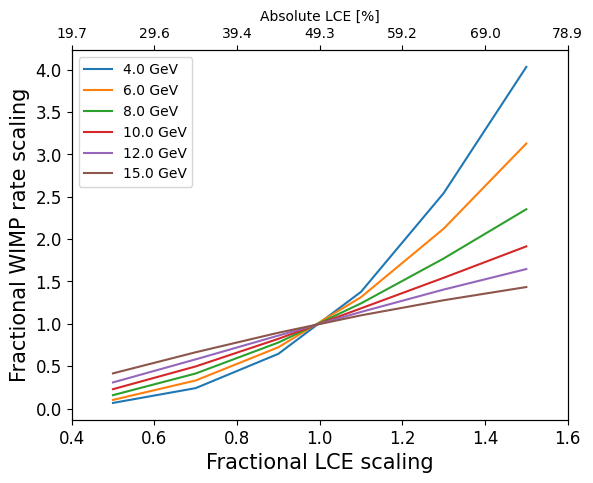

In [6]:
import warnings
warnings.filterwarnings('ignore')

plt.figure()

for wimp_mass_GeV in tqdm(wimp_masses_GeV):
    scalings = get_wimp_rate_scalings(wimp_mass_GeV, lce_scaling_factors)
    plt.plot(list(scalings.keys()), list(scalings.values()), label=f'{wimp_mass_GeV} GeV')
    
plt.legend()

ax = plt.gca()
plt.xlabel('Fractional LCE scaling')
plt.ylabel('Fractional WIMP rate scaling')
plt.xticks(ax.get_xticks(), fontsize=12)
plt.yticks(fontsize=12)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

def absolute_lce(fractional_lce):
    return fractional_lce * 0.493 * 100

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
lce_ticks = absolute_lce(ax.get_xticks())
lce_ticks = [f'{tick:.1f}' for tick in lce_ticks]
ax2.set_xticklabels(lce_ticks)
ax2.set_xlabel('Absolute LCE [%]')